## Modeling - artificial dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV, VarianceThreshold, SelectFromModel, SelectKBest, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from boruta import BorutaPy
# from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, make_scorer
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import loguniform, uniform, randint

sns.set_style('whitegrid')
sns.set_palette('dark')

rs=123

In [2]:
# evaluation metric
def evaluation_metric(y_true, y_pred, m):
    """
    Balanced accuracy calculation with penalty depending on the number of features.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    ba = (1/2)*((tp/(tp+fn)) + (tn/(fp+tn)))
    penalty = 0.01*max(0, (1/200)*m - (1/4))
    return ba - penalty

### Data preparation

In [3]:
# loading data
x_train = pd.read_csv('./data/digits_train.data', sep=" ", header=None)
x_test = pd.read_csv('./data/digits_valid.data', sep=" ", header=None)
y_train = np.array(pd.read_csv('./data/digits_train.labels', header=None)[0].tolist())

In [4]:
# dropping unnecessary NaN columns
x_train.drop(columns=x_train.columns[-1], axis=1, inplace=True)
x_test.drop(columns=x_test.columns[-1], axis=1, inplace=True)

In [5]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,550,0,495,0,0,0,0,976,0,0,...,0,0,0,991,991,0,0,0,0,983
1,0,0,0,0,0,0,0,976,0,0,...,0,475,0,991,0,0,991,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,742,0,0,0,0,684,0,956,...,0,0,0,0,0,0,674,0,0,838
4,0,0,0,0,0,0,0,608,0,979,...,991,0,0,828,0,0,0,0,0,0


In [6]:
# data size
print('Train: ' , x_train.shape)
print('Test: ', x_test.shape)

Train:  (6000, 5000)
Test:  (1000, 5000)


-1    3000
 1    3000
dtype: int64


<AxesSubplot:ylabel='count'>

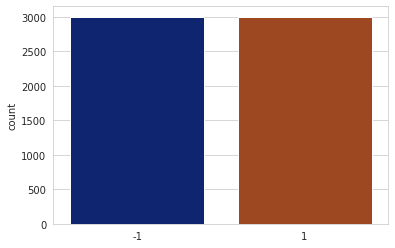

In [7]:
# target distribution
print(pd.Series(y_train).value_counts())
sns.countplot(y_train)

In [8]:
# train-valid split (stratification not needed - target perfectly balanced)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [9]:
# crossvalidation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

In [10]:
# scaling - można spróbować innej metody i porównać
std = StandardScaler()
x_train_scaled = std.fit_transform(x_train)
x_valid_scaled = std.transform(x_valid)

### SelectKBest + Recursive Feature Elimination (RFE)

#### SelectKBest

In [11]:
k=100

In [12]:
selector = SelectKBest(score_func=mutual_info_classif, k=k)

selector.fit(x_train_scaled, y_train)

SelectKBest(k=100, score_func=<function mutual_info_classif at 0x7efc7aa451e0>)

In [13]:
x_train_kbest = selector.transform(x_train_scaled)

In [14]:
x_valid_kbest = selector.transform(x_valid_scaled)

#### Recursive Feature Elimination (RFE)

In [15]:
scores_ba = []
scores = []
n_of_features = np.arange(1,51,1)
for n in tqdm(n_of_features):
    clf = RandomForestClassifier(random_state=rs)
    rfe = RFE(clf, n_features_to_select=n)
    rfe.fit(x_train_kbest, y_train)
    x_train_rfe = rfe.transform(x_train_kbest)
    x_valid_rfe = rfe.transform(x_valid_kbest)
    rf = RandomForestClassifier(random_state=rs)
    rf.fit(x_train_rfe, y_train)
    y_pred = rf.predict(x_valid_rfe)
    scores_ba.append(balanced_accuracy_score(y_valid, y_pred))
    scores.append(evaluation_metric(y_valid, y_pred, x_valid_rfe.shape[1]))

100%|██████████| 50/50 [25:34<00:00, 30.69s/it]


In [16]:
results = pd.DataFrame([n_of_features, scores_ba, scores], 
                        index = ['No. of features', 'Balanced accuracy', 'Final score']).T
results.to_csv('./results_10/digits_rfe_results.csv', index=False)

<AxesSubplot:>

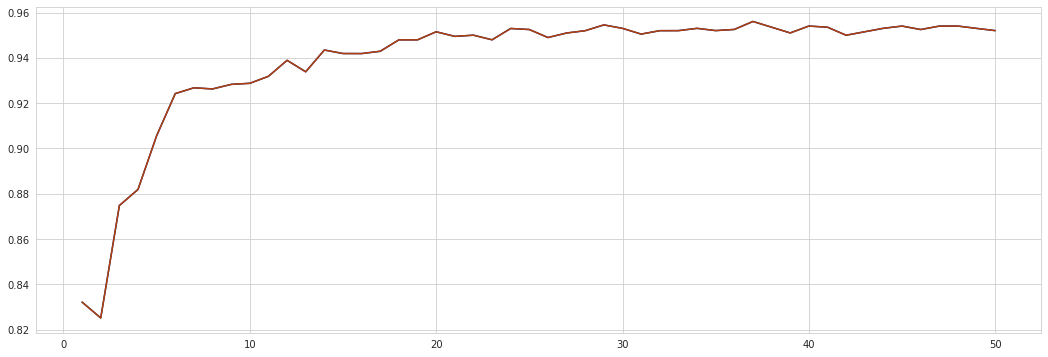

In [17]:
plt.figure(figsize=(18,6)) # pododawać jakieś legendy do tych plotów czy coś
sns.lineplot(x=n_of_features, y=scores, label='Custom score') # niebieska
sns.lineplot(x=n_of_features, y=scores_ba, label='Balanced accuracy') # brązowa
plt.xlabel('Number of features', size=15)
plt.ylabel('Score', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Digits', size=17)
plt.legend(fontsize=15)

In [18]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.95] # do zmiany na podstawie wyników !!!
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
scores_ba_best = [round(elem, 5) for i, elem in enumerate(scores_ba) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
best_results = pd.DataFrame([n_of_features_best, scores_ba_best, scores_best], 
                            index = ['No. of features', 'Balanced accuracy', 'Final score']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0)

,No. of features,Balanced accuracy,Final score
0,14.000000,0.943460,0.943460
1,15.000000,0.941900,0.941900
2,16.000000,0.941890,0.941890
3,17.000000,0.942910,0.942910
4,18.000000,0.947950,0.947950
5,19.000000,0.947950,0.947950
6,20.000000,0.951500,0.951500
7,21.000000,0.949480,0.949480
8,22.000000,0.950000,0.950000
9,23.000000,0.947960,0.947960


### SelectKBest + RFECV

#### Recursive Feature Elimination with cross-validation (RFECV)

In [19]:
clf = RandomForestClassifier(random_state=rs)

rfecv = RFECV(clf, step=1, cv=skf, scoring='balanced_accuracy')
# potrzebujemy jakos podać liczbe zmiennych wynikowych ale nie ma chyba jak tego zagnieździć :( 
# make_scorer(evaluation_metric, m=LICZBA ZMIENNYCH) (parametr evaluation metric, musi byc podany poza funkcja w tym przypadku)

rfecv = rfecv.fit(x_train_kbest, y_train)

In [20]:
x_train_rfecv = rfecv.transform(x_train_kbest)

In [21]:
x_valid_rfecv = rfecv.transform(x_valid_kbest)

In [22]:
x_valid_rfecv.shape[1]

51

In [23]:
rf = RandomForestClassifier(random_state=rs)
rf.fit(x_train_rfecv, y_train)

RandomForestClassifier(random_state=123)

In [24]:
balanced_accuracy_score(y_valid, rf.predict(x_valid_rfecv))

0.9550026733711823

In [25]:
evaluation_metric(y_valid, rf.predict(x_valid_rfecv), x_valid_rfecv.shape[1])

0.9549526733711823

### SelectKBest + Step Forward Feature Selection

#### Step Forward Feature Selection

In [26]:
clf = RandomForestClassifier(random_state=rs)
sfsf = SequentialFeatureSelector(clf,
           k_features='best', # zobaczyć co wypluje, jak słabo to testować 1-30 features tak jak dla rfe na przykład
            # chyba ze za długo sie bedzie liczył to od razu
           forward=True,
           floating=False,
           verbose=2,
           scoring='balanced_accuracy',
           cv=skf)

sfsf.fit(x_train_kbest, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished

[2022-05-26 14:52:43] Features: 1/100 -- score: 0.8329610478631075[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  1.2min finished

[2022-05-26 14:53:53] Features: 2/100 -- score: 0.8631990080599058[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  1.2min finished

[2022-05-26 14:55:05] Features: 3/100 -- score: 0.8918089162764906[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                          estimator=RandomForestClassifier(random_state=123),
                          k_features='best', scoring='balanced_accuracy',
                          verbose=2)

In [27]:
x_train_sfsf = sfsf.transform(x_train_kbest)

In [28]:
x_valid_sfsf = sfsf.transform(x_valid_kbest)

In [29]:
x_valid_sfsf.shape[1]

54

In [30]:
rf = RandomForestClassifier(random_state=rs)
rf.fit(x_train_sfsf, y_train)

RandomForestClassifier(random_state=123)

In [31]:
balanced_accuracy_score(y_valid, rf.predict(x_valid_sfsf))

0.9504201886461314

In [32]:
evaluation_metric(y_valid, rf.predict(x_valid_sfsf), x_valid_sfsf.shape[1])

0.9502201886461314

### SelectKBest + Step Backward Feature Selection

#### Step Backward Feature Selection

In [33]:
clf = RandomForestClassifier(random_state=rs)
sfsb = SequentialFeatureSelector(clf,
           k_features='best', # zobaczyć co wypluje, jak słabo to testować 1-30 features tak jak dla rfe na przykład
            # chyba ze za długo sie bedzie liczył to od razu
           forward=False,
           floating=False,
           verbose=2,
           scoring='balanced_accuracy',
           cv=skf)

sfsb.fit(x_train_kbest, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished

[2022-05-26 16:48:39] Features: 99/1 -- score: 0.9545281096358679[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  3.1min finished

[2022-05-26 16:51:45] Features: 98/1 -- score: 0.9540398809501565[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  3.1min finished

[2022-05-26 16:54:50] Features: 97/1 -- score: 0.9555250294190575[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                          estimator=RandomForestClassifier(random_state=123),
                          forward=False, k_features='best',
                          scoring='balanced_accuracy', verbose=2)

In [34]:
x_train_sfsb = sfsb.transform(x_train_kbest)

In [35]:
x_valid_sfsb = sfsb.transform(x_valid_kbest)

In [36]:
x_valid_sfsb.shape[1]

82

In [37]:
rf = RandomForestClassifier(random_state=rs)
rf.fit(x_train_sfsb, y_train)

RandomForestClassifier(random_state=123)

In [38]:
balanced_accuracy_score(y_valid, rf.predict(x_valid_sfsb))

0.9524650114893738

In [39]:
evaluation_metric(y_valid, rf.predict(x_valid_sfsb), x_valid_sfsb.shape[1])

0.9508650114893737

### Boruta

In [11]:
max_depth = np.arange(2,16,1)
n_of_features = []
scores = []
scores_ba = []
for md in tqdm(max_depth):
    rf = RandomForestClassifier(class_weight='balanced', max_depth=md, random_state=rs) # z dokumentacji, można się pobawić moze coś zmieni
    rf.fit(x_train_scaled, y_train)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(np.array(x_train_scaled), y_train)    
    n_of_features.append(feat_selector.support_.sum())
    x_train_boruta = feat_selector.transform(np.array(x_train_scaled))
    x_valid_boruta = feat_selector.transform(np.array(x_valid_scaled))
    rf = RandomForestClassifier(random_state=rs) # moze próbowac grida zeby polepszyć
    rf.fit(x_train_boruta, y_train)
    scores_ba.append(balanced_accuracy_score(y_valid, rf.predict(x_valid_boruta)))
    scores.append(evaluation_metric(y_valid, rf.predict(x_valid_boruta), x_valid_boruta.shape[1]))

  0%|          | 0/14 [00:00<?, ?it/s]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	643
Tentative: 	890
Rejected: 	3467
Iteration: 	9 / 100
Confirmed: 	643
Tentative: 	890
Rejected: 	3467
Iteration: 	10 / 100
Confirmed: 	643
Tentative: 	890
Rejected: 	3467
Iteration: 	11 / 100
Confirmed: 	643
Tentative: 	890
Rejected: 	3467
Iteration: 	12 / 100
Confirmed: 	668
Tentative: 	687
Rejected: 	3645
Iteration: 	13 / 100
Confirmed: 	668
Tentative: 	687
Rejected: 	3645
Iteration: 	14 / 100
Confirmed: 	668
Tentative: 	687
Rejected: 	3645
Iteration: 	15 / 100
Confirmed: 	668
Tentative: 	687
Rejected: 	3645
It

  7%|▋         | 1/14 [17:27<3:46:58, 1047.57s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	884
Tentative: 	837
Rejected: 	3279
Iteration: 	9 / 100
Confirmed: 	884
Tentative: 	837
Rejected: 	3279
Iteration: 	10 / 100
Confirmed: 	884
Tentative: 	837
Rejected: 	3279
Iteration: 	11 / 100
Confirmed: 	884
Tentative: 	837
Rejected: 	3279
Iteration: 	12 / 100
Confirmed: 	912
Tentative: 	678
Rejected: 	3410
Iteration: 	13 / 100
Confirmed: 	912
Tentative: 	678
Rejected: 	3410
Iteration: 	14 / 100
Confirmed: 	912
Tentative: 	678
Rejected: 	3410
Iteration: 	15 / 100
Confirmed: 	912
Tentative: 	678
Rejected: 	3410
It

 14%|█▍        | 2/14 [38:25<3:54:18, 1171.54s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1018
Tentative: 	714
Rejected: 	3268
Iteration: 	9 / 100
Confirmed: 	1018
Tentative: 	714
Rejected: 	3268
Iteration: 	10 / 100
Confirmed: 	1018
Tentative: 	714
Rejected: 	3268
Iteration: 	11 / 100
Confirmed: 	1018
Tentative: 	714
Rejected: 	3268
Iteration: 	12 / 100
Confirmed: 	1049
Tentative: 	683
Rejected: 	3268
Iteration: 	13 / 100
Confirmed: 	1049
Tentative: 	588
Rejected: 	3363
Iteration: 	14 / 100
Confirmed: 	1049
Tentative: 	588
Rejected: 	3363
Iteration: 	15 / 100
Confirmed: 	1049
Tentative: 	588
Rejected: 

 21%|██▏       | 3/14 [1:00:01<3:45:10, 1228.19s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1048
Tentative: 	626
Rejected: 	3326
Iteration: 	9 / 100
Confirmed: 	1048
Tentative: 	626
Rejected: 	3326
Iteration: 	10 / 100
Confirmed: 	1048
Tentative: 	626
Rejected: 	3326
Iteration: 	11 / 100
Confirmed: 	1048
Tentative: 	626
Rejected: 	3326
Iteration: 	12 / 100
Confirmed: 	1063
Tentative: 	611
Rejected: 	3326
Iteration: 	13 / 100
Confirmed: 	1063
Tentative: 	515
Rejected: 	3422
Iteration: 	14 / 100
Confirmed: 	1063
Tentative: 	515
Rejected: 	3422
Iteration: 	15 / 100
Confirmed: 	1063
Tentative: 	515
Rejected: 

 29%|██▊       | 4/14 [1:21:35<3:29:00, 1254.08s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1006
Tentative: 	620
Rejected: 	3374
Iteration: 	9 / 100
Confirmed: 	1006
Tentative: 	620
Rejected: 	3374
Iteration: 	10 / 100
Confirmed: 	1006
Tentative: 	620
Rejected: 	3374
Iteration: 	11 / 100
Confirmed: 	1006
Tentative: 	620
Rejected: 	3374
Iteration: 	12 / 100
Confirmed: 	1035
Tentative: 	591
Rejected: 	3374
Iteration: 	13 / 100
Confirmed: 	1035
Tentative: 	498
Rejected: 	3467
Iteration: 	14 / 100
Confirmed: 	1035
Tentative: 	498
Rejected: 	3467
Iteration: 	15 / 100
Confirmed: 	1035
Tentative: 	498
Rejected: 

 36%|███▌      | 5/14 [1:42:41<3:08:46, 1258.48s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1036
Tentative: 	530
Rejected: 	3434
Iteration: 	9 / 100
Confirmed: 	1036
Tentative: 	530
Rejected: 	3434
Iteration: 	10 / 100
Confirmed: 	1036
Tentative: 	530
Rejected: 	3434
Iteration: 	11 / 100
Confirmed: 	1036
Tentative: 	530
Rejected: 	3434
Iteration: 	12 / 100
Confirmed: 	1052
Tentative: 	514
Rejected: 	3434
Iteration: 	13 / 100
Confirmed: 	1052
Tentative: 	435
Rejected: 	3513
Iteration: 	14 / 100
Confirmed: 	1052
Tentative: 	435
Rejected: 	3513
Iteration: 	15 / 100
Confirmed: 	1052
Tentative: 	435
Rejected: 

 43%|████▎     | 6/14 [2:02:48<2:45:27, 1240.89s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	999
Tentative: 	518
Rejected: 	3483
Iteration: 	9 / 100
Confirmed: 	999
Tentative: 	518
Rejected: 	3483
Iteration: 	10 / 100
Confirmed: 	999
Tentative: 	518
Rejected: 	3483
Iteration: 	11 / 100
Confirmed: 	999
Tentative: 	518
Rejected: 	3483
Iteration: 	12 / 100
Confirmed: 	1006
Tentative: 	407
Rejected: 	3587
Iteration: 	13 / 100
Confirmed: 	1006
Tentative: 	407
Rejected: 	3587
Iteration: 	14 / 100
Confirmed: 	1006
Tentative: 	407
Rejected: 	3587
Iteration: 	15 / 100
Confirmed: 	1006
Tentative: 	407
Rejected: 	358

 50%|█████     | 7/14 [2:22:07<2:21:38, 1214.06s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	944
Tentative: 	518
Rejected: 	3538
Iteration: 	9 / 100
Confirmed: 	944
Tentative: 	518
Rejected: 	3538
Iteration: 	10 / 100
Confirmed: 	944
Tentative: 	518
Rejected: 	3538
Iteration: 	11 / 100
Confirmed: 	944
Tentative: 	518
Rejected: 	3538
Iteration: 	12 / 100
Confirmed: 	952
Tentative: 	412
Rejected: 	3636
Iteration: 	13 / 100
Confirmed: 	952
Tentative: 	412
Rejected: 	3636
Iteration: 	14 / 100
Confirmed: 	952
Tentative: 	412
Rejected: 	3636
Iteration: 	15 / 100
Confirmed: 	952
Tentative: 	412
Rejected: 	3636
It

 57%|█████▋    | 8/14 [2:40:38<1:58:07, 1181.33s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	922
Tentative: 	506
Rejected: 	3572
Iteration: 	9 / 100
Confirmed: 	922
Tentative: 	506
Rejected: 	3572
Iteration: 	10 / 100
Confirmed: 	922
Tentative: 	506
Rejected: 	3572
Iteration: 	11 / 100
Confirmed: 	922
Tentative: 	506
Rejected: 	3572
Iteration: 	12 / 100
Confirmed: 	933
Tentative: 	399
Rejected: 	3668
Iteration: 	13 / 100
Confirmed: 	933
Tentative: 	399
Rejected: 	3668
Iteration: 	14 / 100
Confirmed: 	933
Tentative: 	399
Rejected: 	3668
Iteration: 	15 / 100
Confirmed: 	933
Tentative: 	399
Rejected: 	3668
It

 64%|██████▍   | 9/14 [2:58:11<1:35:06, 1141.22s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	869
Tentative: 	525
Rejected: 	3606
Iteration: 	9 / 100
Confirmed: 	869
Tentative: 	525
Rejected: 	3606
Iteration: 	10 / 100
Confirmed: 	869
Tentative: 	525
Rejected: 	3606
Iteration: 	11 / 100
Confirmed: 	869
Tentative: 	525
Rejected: 	3606
Iteration: 	12 / 100
Confirmed: 	877
Tentative: 	418
Rejected: 	3705
Iteration: 	13 / 100
Confirmed: 	877
Tentative: 	418
Rejected: 	3705
Iteration: 	14 / 100
Confirmed: 	877
Tentative: 	418
Rejected: 	3705
Iteration: 	15 / 100
Confirmed: 	877
Tentative: 	418
Rejected: 	3705
It

 71%|███████▏  | 10/14 [3:14:54<1:13:14, 1098.52s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	847
Tentative: 	537
Rejected: 	3616
Iteration: 	9 / 100
Confirmed: 	847
Tentative: 	537
Rejected: 	3616
Iteration: 	10 / 100
Confirmed: 	847
Tentative: 	537
Rejected: 	3616
Iteration: 	11 / 100
Confirmed: 	847
Tentative: 	537
Rejected: 	3616
Iteration: 	12 / 100
Confirmed: 	849
Tentative: 	443
Rejected: 	3708
Iteration: 	13 / 100
Confirmed: 	849
Tentative: 	443
Rejected: 	3708
Iteration: 	14 / 100
Confirmed: 	849
Tentative: 	443
Rejected: 	3708
Iteration: 	15 / 100
Confirmed: 	849
Tentative: 	443
Rejected: 	3708
It

 79%|███████▊  | 11/14 [3:30:54<52:48, 1056.25s/it]  

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	825
Tentative: 	536
Rejected: 	3639
Iteration: 	9 / 100
Confirmed: 	825
Tentative: 	536
Rejected: 	3639
Iteration: 	10 / 100
Confirmed: 	825
Tentative: 	536
Rejected: 	3639
Iteration: 	11 / 100
Confirmed: 	825
Tentative: 	536
Rejected: 	3639
Iteration: 	12 / 100
Confirmed: 	835
Tentative: 	420
Rejected: 	3745
Iteration: 	13 / 100
Confirmed: 	835
Tentative: 	420
Rejected: 	3745
Iteration: 	14 / 100
Confirmed: 	835
Tentative: 	420
Rejected: 	3745
Iteration: 	15 / 100
Confirmed: 	835
Tentative: 	420
Rejected: 	3745
It

 86%|████████▌ | 12/14 [3:46:03<33:42, 1011.35s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	795
Tentative: 	543
Rejected: 	3662
Iteration: 	9 / 100
Confirmed: 	795
Tentative: 	543
Rejected: 	3662
Iteration: 	10 / 100
Confirmed: 	795
Tentative: 	543
Rejected: 	3662
Iteration: 	11 / 100
Confirmed: 	795
Tentative: 	543
Rejected: 	3662
Iteration: 	12 / 100
Confirmed: 	803
Tentative: 	439
Rejected: 	3758
Iteration: 	13 / 100
Confirmed: 	803
Tentative: 	439
Rejected: 	3758
Iteration: 	14 / 100
Confirmed: 	803
Tentative: 	439
Rejected: 	3758
Iteration: 	15 / 100
Confirmed: 	803
Tentative: 	439
Rejected: 	3758
It

 93%|█████████▎| 13/14 [4:00:29<16:07, 967.31s/it] 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	767
Tentative: 	571
Rejected: 	3662
Iteration: 	9 / 100
Confirmed: 	767
Tentative: 	571
Rejected: 	3662
Iteration: 	10 / 100
Confirmed: 	767
Tentative: 	571
Rejected: 	3662
Iteration: 	11 / 100
Confirmed: 	767
Tentative: 	571
Rejected: 	3662
Iteration: 	12 / 100
Confirmed: 	771
Tentative: 	452
Rejected: 	3777
Iteration: 	13 / 100
Confirmed: 	771
Tentative: 	452
Rejected: 	3777
Iteration: 	14 / 100
Confirmed: 	771
Tentative: 	452
Rejected: 	3777
Iteration: 	15 / 100
Confirmed: 	771
Tentative: 	452
Rejected: 	3777
It

100%|██████████| 14/14 [4:14:10<00:00, 1089.35s/it]


In [12]:
results = pd.DataFrame([max_depth, n_of_features, scores_ba, scores], 
                        index = ['Max depth','No. of features', 'Balanced accuracy', 'Final score']).T
results.to_csv('./results_10/digits_boruta_results.csv', index=False)

<AxesSubplot:>

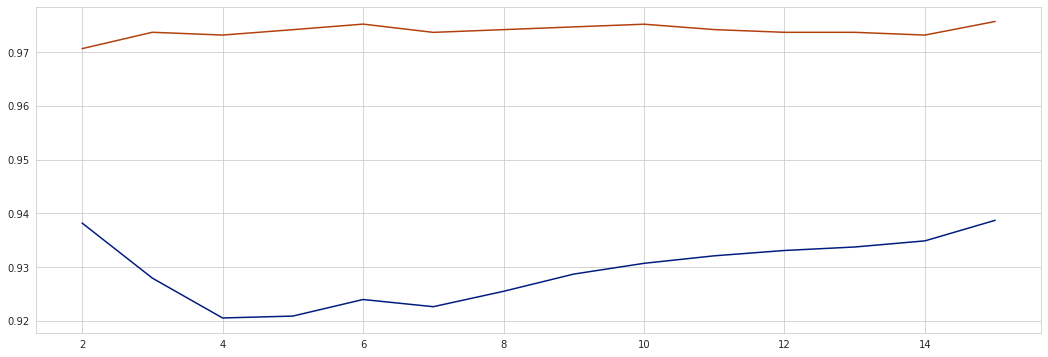

In [13]:
plt.figure(figsize=(18,6))
sns.lineplot(x=max_depth, y=scores, label='Custom score') # niebieska
sns.lineplot(x=max_depth, y=scores_ba, label='Balanced accuracy') # brązowa
plt.xlabel('Number of features', size=15)
plt.ylabel('Score', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Digits', size=17)
plt.legend(fontsize=15)

In [14]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.93] # próg do zmiany na podstawie wyników !!!
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
scores_ba_best = [round(elem, 5) for i, elem in enumerate(scores_ba) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
max_depth_best = [int(elem) for i, elem in enumerate(max_depth) if i in ids_best]
best_results = pd.DataFrame([max_depth_best, n_of_features_best, scores_ba_best, scores_best], 
                            index = ['Max depth', 'No. of features', 'Balanced accuracy', 'Final score']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0)

,Max depth,No. of features,Balanced accuracy,Final score
0,2.000000,699.000000,0.970660,0.938210
1,15.000000,790.000000,0.975720,0.938720
2,14.000000,816.000000,0.973190,0.934890
3,13.000000,849.000000,0.973690,0.933740
4,12.000000,862.000000,0.973690,0.933090
5,11.000000,892.000000,0.974200,0.932100
6,10.000000,940.000000,0.975210,0.930710
7,3.000000,965.000000,0.973700,0.927950
8,9.000000,970.000000,0.974710,0.928710
9,8.000000,1024.000000,0.974200,0.925500


### L1

In [15]:
scores = []
scores_ba = []
n_of_features = []
cs = np.arange(0.0005, 0.05, 0.001)
for c in tqdm(cs):
    selector = SelectFromModel(LinearSVC(C=c, penalty="l1", dual=False, random_state=rs).fit(x_train_scaled, y_train), prefit=True)
    x_train_l1 = selector.transform(x_train_scaled)
    x_valid_l1 = selector.transform(x_valid_scaled)
    estimator = RandomForestClassifier(random_state=rs) 
    estimator.fit(x_train_l1, y_train)
    y_pred = estimator.predict(x_valid_l1)
    n_of_features.append(x_train_l1.shape[1])
    scores_ba.append(balanced_accuracy_score(y_valid, y_pred))
    scores.append(evaluation_metric(y_valid, estimator.predict(x_valid_l1), x_valid_l1.shape[1]))

100%|██████████| 50/50 [02:52<00:00,  3.45s/it]


In [16]:
results = pd.DataFrame([cs, n_of_features, scores_ba, scores], 
                        index = ['C','No. of features', 'Balanced accuracy', 'Final score']).T
results.to_csv('./results_10/digits_l1_results.csv', index=False)

<AxesSubplot:>

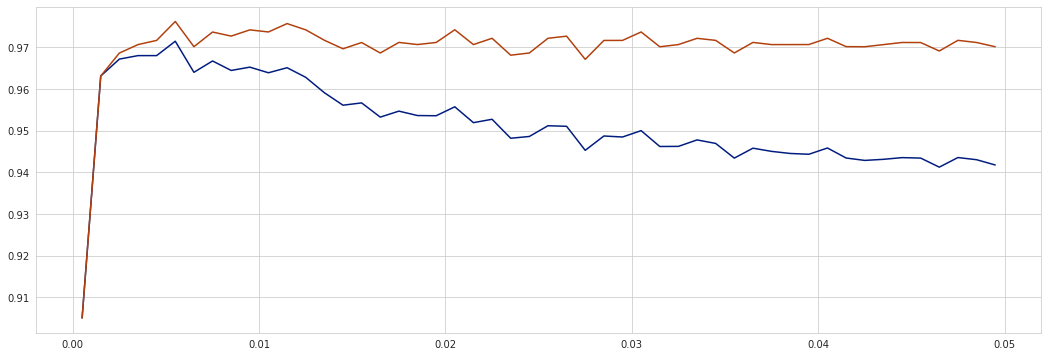

In [17]:
plt.figure(figsize=(18,6))
sns.lineplot(x=cs, y=scores, label='Custom score') # niebieska
sns.lineplot(x=cs, y=scores_ba, label='Balanced accuracy') # brązowa
plt.xlabel('Number of features', size=15)
plt.ylabel('Score', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Digits', size=17)
plt.legend(fontsize=15)

In [18]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.96] # ew. do zmiany na podstawie wyników !!!
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
scores_ba_best = [round(elem, 5) for i, elem in enumerate(scores_ba) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
best_results = pd.DataFrame([n_of_features_best, scores_ba_best, scores_best], 
                            index = ['No. of features', 'Balanced accuracy', 'Final score']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0)

,No. of features,Balanced accuracy,Final score
0,43.000000,0.963130,0.963130
1,79.000000,0.968640,0.967190
2,103.000000,0.970680,0.968030
3,123.000000,0.971680,0.968030
4,145.000000,0.976230,0.971480
5,173.000000,0.970170,0.964020
6,189.000000,0.973690,0.966740
7,215.000000,0.972720,0.964470
8,229.000000,0.974210,0.965260
9,246.000000,0.973710,0.963910
